In [35]:
# imports
import pysam
import main.functions as fnc
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from maxentpy.maxent import load_matrix5, load_matrix3, score5, score3
from collections import defaultdict

In [36]:
bamFile = "./ref/ENCFF950KXS.bam"
genomeFile = "./data/Homo_sapiens.GRCh38.dna_sm.primary_assembly.fa.gz"

genome = fnc.openGenomeFile(genomeFile)

In [37]:
def getSpliceCoordsAndCounts(bamFile, genome):

    bam = pysam.AlignmentFile(bamFile, "rb")

    fivePrimeSites = defaultdict(int)
    threePrimeSites = defaultdict(int)

    # go through each read in the bam file and 
    for read in bam.fetch(): # make it easier to run by only doing the 14th chromosome (short one)
        
        if read.cigar is None: # make sure read has a cigar string
            continue

        # Get the reads reference name (chrom) and strand info
        chrom = bam.get_reference_name(read.reference_id).strip("chr") # get rid of "chr" because genome file just uses number

        if "ERCC" in chrom:
            continue

        elif "random" in chrom or "Un" in chrom:
            rawChr = chrom.split('_')[1]
            vIndx = rawChr.rfind('v')
            chrom = rawChr[:vIndx] + '.' + rawChr[vIndx + 1:] # BAM file chromosome format e.g "22_KI270733v1_random" and genome uses "KI270733.1" so manipulate string for correct format

        elif chrom == "M": # genome file uses "MT" for mitochondrial seq
            chrom = "MT"

        strand = '-' if read.is_reverse else '+'

        # start the the reference position at the reference start
        refPos = read.reference_start

        # go through the cigar string to find splice sites
        for operation, length in read.cigartuples:
            
            if operation == 3:  # cigar == 3 corresponds to the 'N' operation which is intronic aka the only thing we're interest in

                intronStart = refPos
                intronEnd = refPos + length

                # determine the splice site coordinates
                if strand == "+":
                    #if intronStart >= 3 and intronEnd < len(genome[chrom]) - 3: # check if enough upstream/downstream nucleotides
                    threePrimeSites[(chrom, intronEnd - 20, intronEnd + 3, strand)] += 1
                    fivePrimeSites[(chrom, intronStart - 3, intronStart + 6, strand)] += 1
                
                elif strand == "-":
                    #if intronStart >= 3 and intronEnd < len(genome[chrom]) - 3: # check if enough upstream/downstream nucleotides
                    threePrimeSites[(chrom, intronStart - 3, intronStart + 20, strand)] += 1
                    fivePrimeSites[(chrom, intronEnd - 6, intronEnd + 3, strand)] += 1
                    
            # update the reference position based on the cigar operation
            if operation in {0, 2, 3, 7, 8}:  # these operations consume reference bases (searched this up)
                refPos += length
        
    bam.close()

    return fivePrimeSites, threePrimeSites

fivePrimeSites, threePrimeSites = getSpliceCoordsAndCounts(bamFile, genome)

In [38]:
# get lists with genome sequences from splice site coordinates
fivePrimeSequences = fnc.extractSequences(list(fivePrimeSites.keys()), genome)
threePrimeSequences = fnc.extractSequences(list(threePrimeSites.keys()), genome)

In [39]:
# use slow version of maxentpy to get strength scores for the splice site sequences
matrix5 = load_matrix5()
matrix3 = load_matrix3()

skipIndx5 = []
fivePrimeStrengths = []
for i, seq5 in enumerate(fivePrimeSequences):
    if "N" in seq5:
        skipIndx5.append(i)
        continue 
    fivePrimeStrengths.append(score5(seq5, matrix5))

skipIndx3 = []
threePrimeStrengths = []
for i, seq3 in enumerate(threePrimeSequences):
    if "N" in seq3:
        skipIndx3.append(i)
        continue
    threePrimeStrengths.append(score3(seq3, matrix3))

In [40]:
# convert everything to numpy arrays so its easier to plot
fivePrimeCounts = list(fivePrimeSites.values())
threePrimeCounts = list(threePrimeSites.values())

# ensure that any removed sequences due to an 'N' being in it also get their counts removed so x and y are the same length lists
for i in skipIndx5:
    del fivePrimeCounts[i]
for i in skipIndx3:
    del threePrimeCounts[i]

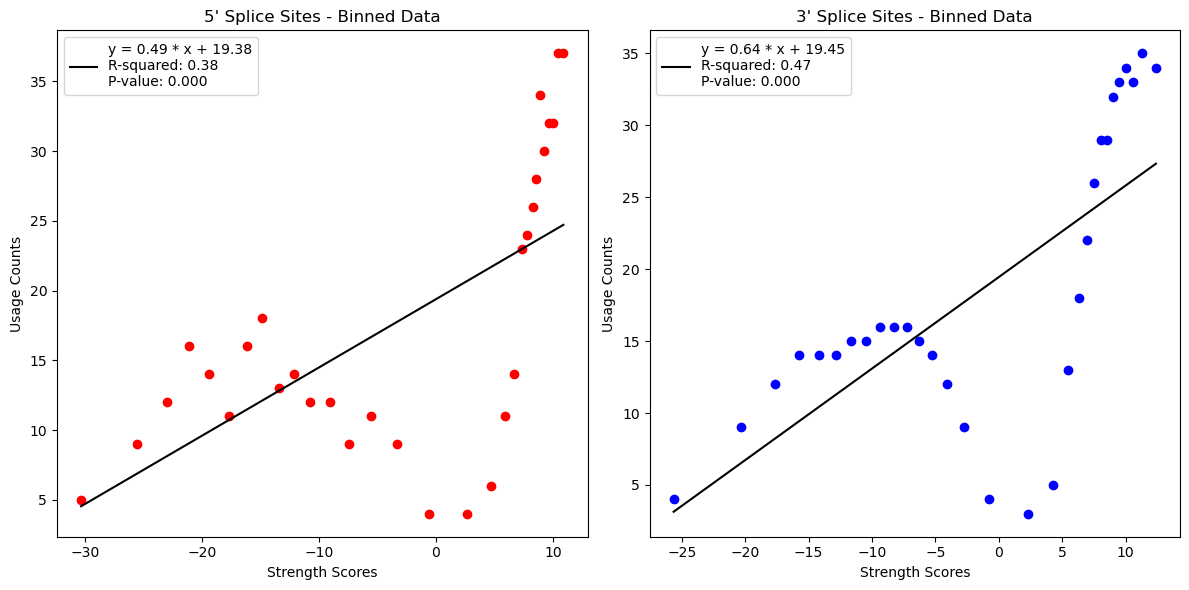

In [41]:
def getBinnedData(x, y, numBins):
    # Combine x and y into a single array and sort by x
    data = np.array(list(zip(x, y)))
    dataSorted = data[np.argsort(data[:, 0])]
    
    # Determine the number of data points per bin
    numPointsPerBin = len(x) // numBins
    
    binnedX = []
    binnedY = []
    
    for i in range(numBins):
        # determine start and end indices for this bin
        startIndex = i * numPointsPerBin
        endIndex = startIndex + numPointsPerBin
        
        # get the data for this bin
        binData = dataSorted[startIndex : endIndex]
        binnedX.append(np.median(binData[:, 0]))  # go through each coordinate ":" and get first value "0" of each (x value)
        binnedY.append(np.median(binData[:, 1]))  # go through each coordinate ":" and get second value "1" of each (y value)
    
    return np.array(binnedX), np.array(binnedY)

binnedX5, binnedY5 = getBinnedData(fivePrimeStrengths, fivePrimeCounts, numBins = 30)
binnedX3, binnedY3 = getBinnedData(threePrimeStrengths, threePrimeCounts, numBins = 30)

def plotWithLine(x, y, ax, clr, title):

    # do linear regression to get a line of best fit, R value, and P value
    slope, intercept, rValue, pValue, _ = linregress(x, y)
    line = slope * x + intercept

    ax.scatter(x, y, color = clr)
    ax.plot(x, line, color = 'black', linestyle = '-', label = f'y = {slope:.2f} * x + {intercept:.2f}\nR-squared: {rValue**2:.2f}\nP-value: {pValue:.3f}')
    ax.set_title(f"{title}")
    ax.set_xlabel('Strength Scores')
    ax.set_ylabel('Usage Counts')
    ax.legend()

fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 6))

plotWithLine(binnedX5, binnedY5, axs[0], "red", "5\' Splice Sites - Binned Data")
plotWithLine(binnedX3, binnedY3, axs[1], "blue", "3\' Splice Sites - Binned Data")

plt.tight_layout()
plt.savefig("./plots/Binned Strength vs Usage")
plt.show()


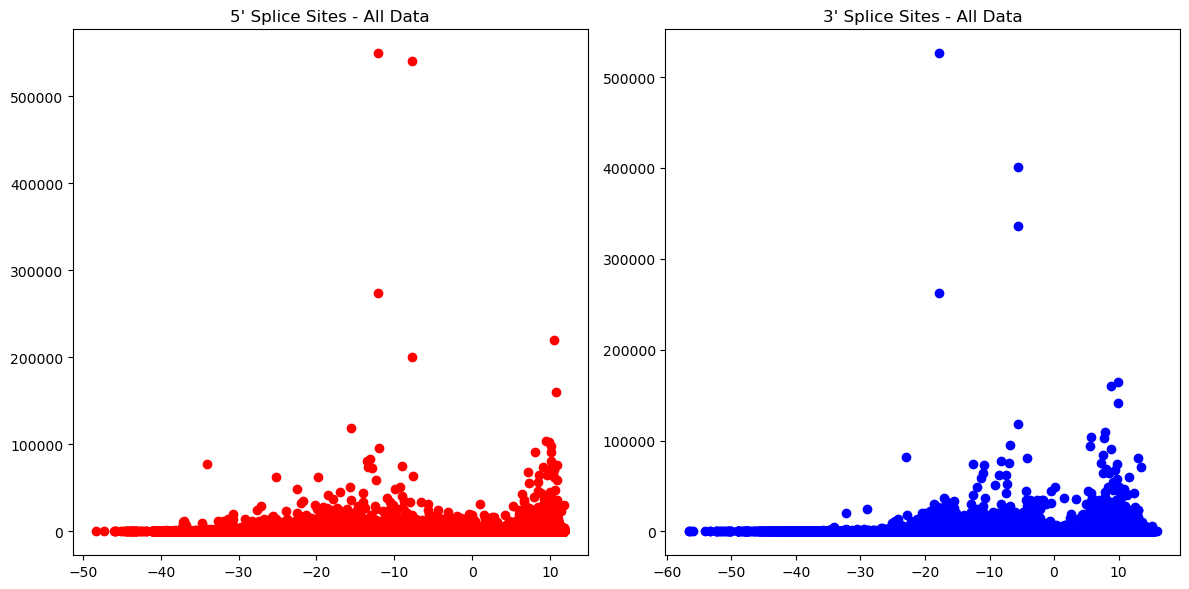

In [42]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12,6))

axs[0].scatter(fivePrimeStrengths, fivePrimeCounts, color = "red")
axs[0].set_title("5\' Splice Sites - All Data")
axs[1].scatter(threePrimeStrengths, threePrimeCounts, color = "blue")
axs[1].set_title("3\' Splice Sites - All Data")

plt.tight_layout()
plt.savefig("./plots/All Data Strength vs Usage")
plt.show()